In [1]:
import torch
import datasets
import os
from utils import plot_adult_results
from sklearn.metrics import accuracy_score, mean_squared_error
from torch import nn
from main import test 
from model import Predictor, Adversary
import seaborn as sns
import matplotlib.pyplot as plt   

In [2]:
ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = os.path.join(ROOT_DIR, "saved_models")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Results UCI Adult Dataset

###### Note that in order to obtain the results we report in our paper, we trained 30 different biased predictors (seed 1 - 30) and 30 different debiased predictors (seed 1 - 30)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 1.</u> Results of our report can be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Biased
> Epochs: 10 <br>
> Batch size: 128 <br>
> Predictor learning rate: 0.1 <br>


- Debiased (Refined implementation)
> Epochs: 15 <br>
> Batch size: 128 <br> 
> Predictor learning rate: 0.001 <br> 
> Adversary learning rate: 0.001 <br>
> Alpha: 0.3 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset 

In [3]:
__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='adult')

sex      income
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
Name: income, dtype: int64
sex      income 
 Female   <=50K.    4831
          >50K.      590
 Male     <=50K.    7604
          >50K.     3256
Name: income, dtype: int64


### Load models 


Filenames of the saved models

In [4]:
pred_biased_filename = "pred_debiased_False_adult_seed_1" 
pred_debiased_filename = "pred_debiased_True_adult_seed_1"

In [5]:
input_dim = next(iter(dataloader_test))[0].shape[1]

# Load the biased model 
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the debiased model
predictor_debiased = Predictor(input_dim).to(DEVICE)
predictor_debiased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_filename), map_location=DEVICE))
predictor_debiased.eval();

### Results on test set

In [6]:
def plot_confusion_matrix(confusion_matrix, plot_title="", ax=None):
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cbar=False, cmap="Blues", ax = ax)
    ax.set_title(plot_title); 
    ax.xaxis.set_ticklabels(['Pred 0', 'Pred 1']); 
    ax.yaxis.set_ticklabels(['True 0', 'True 1']);
    
def plot_confusion_matrices(confusion_matrix_male, confusion_matrix_female, plot_title=""):
    fig, axs = plt.subplots(1, 2, figsize=(7,2))
    plot_confusion_matrix(confusion_matrix_male, plot_title="Male", ax=axs[0])
    plot_confusion_matrix(confusion_matrix_female, plot_title="Female", ax=axs[1])
    fig.suptitle(plot_title, fontsize=15)
    plt.tight_layout()
    plt.show()
    
def print_results(accuracy, mutual_info, neg_fpr, pos_fpr, neg_fnr, pos_fnr, model_type=""):
    print("-------------------------------------------------------------------")
    print("RESULTS %s \n"%(model_type.upper()))
    print("Test accuracy predictor: {:.5f}".format(accuracy))
    print("Mutual information I(Z; Y_hat | Y): {:.5f}\n".format(mutual_info))
    print("False Postive Rates (FPR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fpr, pos_fpr))
    print("False Negative Rates (FNR):")
    print("      Female: {:.5f} || Male: {:.5f}".format(neg_fnr, pos_fnr))
    print()
    print("Absolute difference FPR between Female vs. Male: {:.5f}".format(abs(neg_fpr - pos_fpr)))
    print("Absolute difference FNR between Female vs. Male: {:.5f}".format(abs(neg_fnr - pos_fnr)))
    print("-------------------------------------------------------------------")

In [7]:
# Results biased predictor
accuracy_b, neg_confusion_mat_b, neg_fpr_b, neg_fnr_b, pos_confusion_mat_b, pos_fpr_b, pos_fnr_b, mutual_info_b = test(dataloader_test, 
                                                                                                           predictor = predictor_biased, 
                                                                                                           adversary = None, 
                                                                                                           criterion = nn.BCELoss(), 
                                                                                                           metric = accuracy_score, 
                                                                                                           device = DEVICE, 
                                                                                                           debias = False, 
                                                                                                           dataset = 'adult', 
                                                                                                           log = False)

# Results debiased predictor 
accuracy_db, neg_confusion_mat_db, neg_fpr_db, neg_fnr_db, pos_confusion_mat_db, pos_fpr_db, pos_fnr_db, mutual_info_db = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           debias = True, 
                                                                                                                           dataset = 'adult', 
                                                                                                                           log = False)

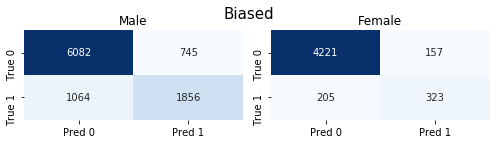

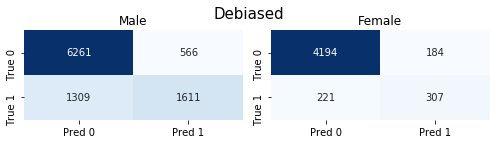

In [8]:
plot_confusion_matrices(pos_confusion_mat_b, neg_confusion_mat_b, plot_title="Biased")
plot_confusion_matrices(pos_confusion_mat_db, neg_confusion_mat_db, plot_title="Debiased")

In [9]:
print_results(accuracy_b, mutual_info_b, neg_fpr_b, pos_fpr_b, neg_fnr_b, pos_fnr_b, model_type="Biased")
print_results(accuracy_db, mutual_info_db, neg_fpr_db, pos_fpr_db, neg_fnr_db, pos_fnr_db, model_type="Debiased")

-------------------------------------------------------------------
RESULTS BIASED 

Test accuracy predictor: 0.85184
Mutual information I(Z; Y_hat | Y): 0.01063

False Postive Rates (FPR):
      Female: 0.03586 || Male: 0.10913
False Negative Rates (FNR):
      Female: 0.38826 || Male: 0.36438

Absolute difference FPR between Female vs. Male: 0.07326
Absolute difference FNR between Female vs. Male: 0.02387
-------------------------------------------------------------------
-------------------------------------------------------------------
RESULTS DEBIASED 

Test accuracy predictor: 0.84440
Mutual information I(Z; Y_hat | Y): 0.00381

False Postive Rates (FPR):
      Female: 0.04203 || Male: 0.08291
False Negative Rates (FNR):
      Female: 0.41856 || Male: 0.44829

Absolute difference FPR between Female vs. Male: 0.04088
Absolute difference FNR between Female vs. Male: 0.02973
-------------------------------------------------------------------


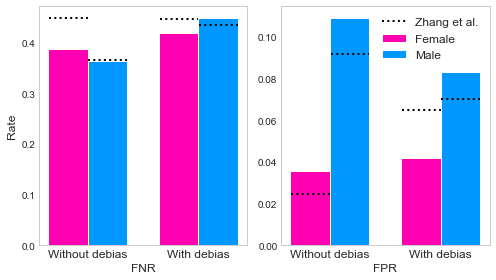

In [10]:
plot_adult_results([neg_fnr_b], [pos_fnr_b], [neg_fpr_b], [pos_fpr_b], 
                   [neg_fnr_db], [pos_fnr_db], [neg_fpr_db], [pos_fpr_db])

# Results UCI Communities and Crime Dataset

###### Note that in order to obtain the results we report in our paper, we trained 30 different biased predictors (seed 1 - 30) and 30 different debiased predictors (seed 1 - 30)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 1.</u> Results of our report can be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Biased
> Epochs: 50 <br>
> Batch size: 32 <br>
> Predictor learning rate: 0.001 <br>


- Debiased
> Epochs: 210 <br>
> Batch size: 64 <br> 
> Predictor learning rate: 0.002 <br> 
> Adversary learning rate: 0.0005 <br>
> Alpha: 1.0 <br> 
> Exponential decayer gamma: 0.96 (decays every 1000 training steps) <br>

### Load dataset

In [ ]:
__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='crime')

### Load models

Filenames of the saved models: 

In [ ]:
pred_biased_filename = "pred_debiased_False_crime_seed_1" 
pred_debiased_filename = "pred_debiased_True_crime_seed_1"

In [ ]:
input_dim = next(iter(dataloader_test))[0].shape[1]

# Load the biased model 
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the debiased model
predictor_debiased = Predictor(input_dim).to(DEVICE)
predictor_debiased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_filename), map_location=DEVICE))
predictor_debiased.eval();

### Results on test set

In [ ]:
# Results biased predictor
MSE_b = test(dataloader_test, 
            predictor = predictor_biased, 
            adversary = None, 
            criterion = nn.MSELoss(), 
            metric = mean_squared_error, 
            device = DEVICE, 
            debias = False, 
            dataset = 'crime', 
            log = False)

# Results debiased predictor 
MSE_db = test(dataloader_test, 
            predictor = predictor_debiased, 
            adversary = None, 
            criterion = nn.MSELoss(), 
            metric = mean_squared_error, 
            device = DEVICE, 
            debias = True, 
            dataset = 'crime', 
            log = False)

In [ ]:
print("Biased predictor mean squared error (MSE): {:.5f}".format(MSE_b))
print("Debiased predictor mean squared error (MSE): {:.5f}".format(MSE_db))

# Results UTKFace Dataset

### !! THIS TEXT NEEDS TO BE UPDATED !! 
###### Note that in order to obtain the results we report in our paper, we trained .... different biased predictors (INSERT SEEDS HERE) and 30 different debiased predictors (INSERT SEEDS HERE)  and averaged the results of those models. <u>In this notebook we will only show the result for a single model trained with the seed set to 1.</u> Results of our report can easily be reproduced by training with the given seeds following the instructions in the README. 

The models where trained with the following settings: <br>
- Biased
> Epochs:  <br>
> Batch size:  <br>
> Predictor learning rate:  <br>


- Debiased
> Epochs:  <br>
> Batch size:  <br> 
> Predictor learning rate:  <br> 
> Adversary learning rate:  <br>
> Alpha:  <br> 
> Exponential decayer gamma: ... (decays every .... training steps) <br>

### Load dataset

#### INSTRUCTIONS TO DOWNLOAD THE DATA HERE

In [ ]:
__, __, dataloader_test = datasets.utils.get_dataloaders(batch_size=128, dataset='images')

### Load models

Filenames of the saved models:

In [ ]:
pred_biased_filename = "pred_debiased_False_images_seed_None" ##### CHANGE FILENAMES
pred_debiased_filename = "pred_debiased_True_images_seed_None"

In [ ]:
input_dim = next(iter(dataloader_test))[0].shape[1]

# Load the biased model 
predictor_biased = Predictor(input_dim).to(DEVICE)
predictor_biased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_biased_filename), map_location=DEVICE))
predictor_biased.eval();

# Load the debiased model
predictor_debiased = Predictor(input_dim).to(DEVICE)
predictor_debiased.load_state_dict(torch.load(os.path.join(MODEL_DIR, pred_debiased_filename), map_location=DEVICE))
predictor_debiased.eval();

### Results on the test set

In [ ]:
# Results biased predictor
accuracy_b, neg_confusion_mat_b, neg_fpr_b, neg_fnr_b, pos_confusion_mat_b, pos_fpr_b, pos_fnr_b, mutual_info_b = test(dataloader_test, 
                                                                                                           predictor = predictor_biased, 
                                                                                                           adversary = None, 
                                                                                                           criterion = nn.BCELoss(), 
                                                                                                           metric = accuracy_score, 
                                                                                                           device = DEVICE, 
                                                                                                           debias = False, 
                                                                                                           dataset = 'images', 
                                                                                                           log = False)
                                                                                                        

# Results debiased predictor 
accuracy_db, neg_confusion_mat_db, neg_fpr_db, neg_fnr_db, pos_confusion_mat_db, pos_fpr_db, pos_fnr_db, mutual_info_db = test(dataloader_test, 
                                                                                                                           predictor = predictor_debiased, 
                                                                                                                           adversary = None, 
                                                                                                                           criterion = nn.BCELoss(), 
                                                                                                                           metric = accuracy_score, 
                                                                                                                           device = DEVICE, 
                                                                                                                           debias = True, 
                                                                                                                           dataset = 'images', 
                                                                                                                           log = False)